In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize,NLTKWordTokenizer
from nltk.tokenize import word_tokenize,wordpunct_tokenize

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,log_loss
from sklearn.metrics import classification_report,precision_recall_curve,balanced_accuracy_score
from sklearn.metrics import roc_auc_score,roc_curve

from sklearn.model_selection import cross_val_score,StratifiedKFold,RepeatedStratifiedKFold
from sklearn.model_selection import KFold,StratifiedKFold

from wordcloud import WordCloud,STOPWORDS

import string as st
import emoji
import re
from collections import Counter

from warnings import filterwarnings
filterwarnings(action='ignore')

### SMS Data

In [2]:
df = pd.read_csv('SMSSpamCollection',sep='\t',names=['Target','messages'])

### Spam words

In [3]:
spam = pd.read_excel("Spam words.xlsx",usecols=[3])
spam = spam.rename(columns={'Unnamed: 3':'spam_words'}).iloc[1:]

spam_word_list = [iterable[1] for iterable in spam.spam_words.items()]

# dropping numerical spam words 
spam_word_list = [spam_word.replace("-"," ") for spam_word in spam_word_list if type(spam_word) == str]

# lower casing spam words
spam_word_list = [spam_word.lower() for spam_word in spam_word_list]

In [4]:
import pickle
with open('spam_list.pickle','wb') as file_1:
    pickle.dump(spam_word_list,file_1)

In [5]:
messages = df['messages'].copy()

In [6]:
df.shape

(5572, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Target    5572 non-null   object
 1   messages  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [8]:
df.dtypes

Target      object
messages    object
dtype: object

## `Target`

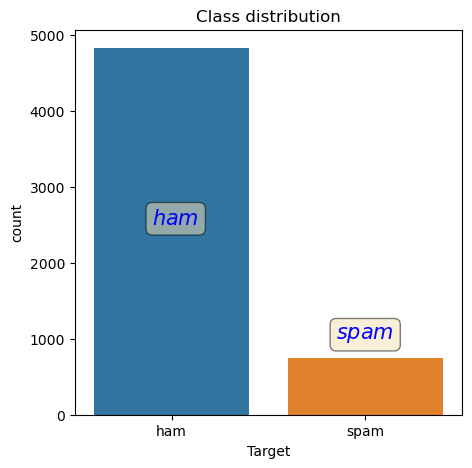

In [9]:
plt.figure(figsize=(5,5))
sns.countplot(df['Target'])

box_style=dict(boxstyle='round', facecolor='wheat', alpha=0.5)

plt.text(-0.1,2500, "$ham$",{'color':'Blue','weight':'heavy','size':15},bbox=box_style)
plt.text(0.85,1000, "$spam$",{'color':'Blue','weight':'heavy','size':15},bbox=box_style)

plt.title("Class distribution")
plt.show()

- By looking at above graph 
- we can infer that the positive class is highly skewed

In [10]:
(df['Target'].value_counts(normalize=True)*100).round(2)

ham     86.59
spam    13.41
Name: Target, dtype: float64

In [11]:
df.shape

(5572, 2)

## `Checking Null values`

In [12]:
df.isnull().sum()

Target      0
messages    0
dtype: int64

## `Lower casing`

In [13]:
series = df['messages'].str.lower()

## `Removing Duplicate SMS`

In [14]:
df = df[~(df.duplicated(keep='first'))]

In [15]:
series = df['messages'].copy()

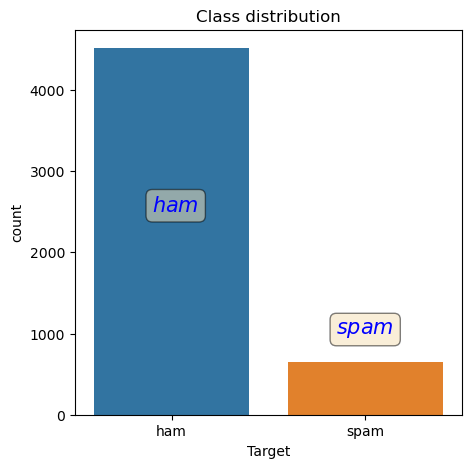

In [16]:
plt.figure(figsize=(5,5))
sns.countplot(df['Target'])

box_style=dict(boxstyle='round', facecolor='wheat', alpha=0.5)

plt.text(-0.1,2500, "$ham$",{'color':'Blue','weight':'heavy','size':15},bbox=box_style)
plt.text(0.85,1000, "$spam$",{'color':'Blue','weight':'heavy','size':15},bbox=box_style)

plt.title("Class distribution")
plt.show()

- First let's try to obtain N_grams and let's calculate number of spam_words in a document

### `1) Raw charecter count`

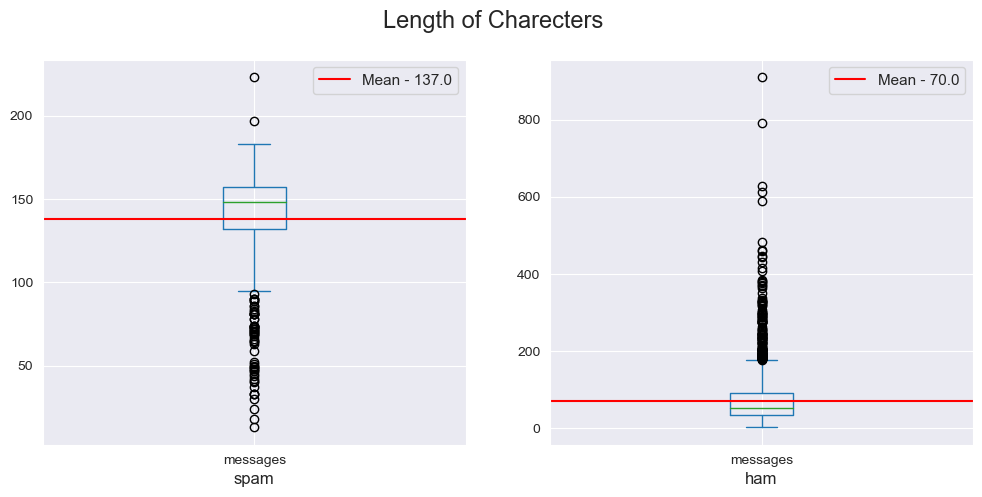

In [17]:
sns.set_style('dark')
fig,ax = plt.subplots(1,2,figsize=(12,5))
for i,category in enumerate(['spam','ham']):
    df[df.Target == category]['messages'].apply(len).plot(kind='box',ax=ax[i])
    ax[i].set_xlabel("")
    ax[i].set_xlabel(category,fontsize=12)
    Mean = df[df.Target == category]['messages'].apply(len).mean()
    ax[i].axhline(Mean,label=f"Mean - {(Mean//1):}",color='red')
    ax[i].grid()
    ax[i].legend(fontsize=11)
fig.suptitle("Length of Charecters",fontsize=17)
plt.show()

In [18]:
df['Raw_char_count'] = df['messages'].str.strip().apply(len)

### `2) spam_word charecteristics`
- Spam words include the charecteristics such as
    - Exclaimatory marks
    - hashtags (#)
    - Hyperlinks (https://)
    - currency followed by Numeric ($400)
    - Phone numbers (+21-985524)

In [19]:
spam = df[df['Target'] =='spam']['messages']
spam_words_spam = round((spam.str.contains('\!{1,}|\#{1,}|https\:\/\/.+|www\.+|\d{4,}|\W\d+').sum()/len(spam)*100),2)

print(f"Total spam word charecteristics in SPAM : {spam_words_spam} %",)

Total spam word charecteristics in SPAM : 96.17 %


In [20]:
ham = df[df['Target'] =='ham']['messages']
spam_words_ham = round((ham.str.contains('\!{1,}|\#{1,}|https\:\/\/.+|www\.+|\d{4,}').sum()/len(ham)*100),2)

print(f"Total spam word charecteristics in HAM : {spam_words_ham} %",)

Total spam word charecteristics in HAM : 16.14 %


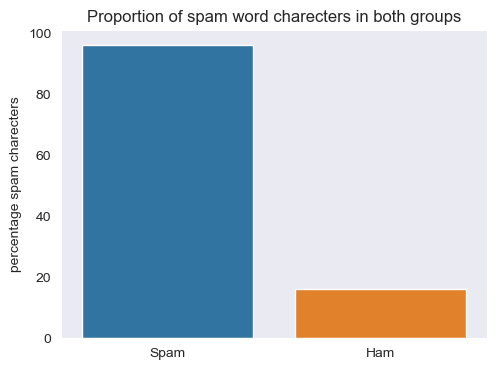

In [21]:
plt.figure(figsize=(5.5,4))
sns.barplot(x=['Spam','Ham'],y=[spam_words_spam,spam_words_ham])
plt.ylabel("percentage spam charecters")
plt.title("Proportion of spam word charecters in both groups",)
plt.show()

- ***So spam contains the maximum spam word charecteristics than 'Ham' as mentioned above***

In [22]:
spam_char = round(df['messages'].str.contains('\!{1,}|\#{1,}|https\:\/\/.+|www\.+|\d{4,}').sum()/len(df)*100,2)

print(f"Corpus containing spam word charecteristics : {spam_char} %")

Corpus containing spam word charecteristics : 25.65 %


In [23]:
df.loc[df['messages'].str.contains('\!{1,}|\#{1,}|https\:\/\/.+|www\.+|\d{4,}'),'spam_chars'] = 1
df['spam_chars'] = df['spam_chars'].fillna(0)
df['spam_chars'] = df['spam_chars'].astype(int)

### `3) Spam word count`

- Spell checking look up table

In [24]:
trans_dict_new = {"n":'and',"fr":'for',"c":'see','b':'be','u':'you',"u\?":'you','ü':'you','wat':'what',
"nah":'no',"wtf.+":'','txtú':'textyou',"rofl":'','ur':'your','muz':'must','won\'t':'will not','wkly':'tickets',
'lol':"",'cuz':'because','yup.':'yes','r':'are','wid':'with','pls':'please','asap':'as soon as possible',
"y\'":"why\?",'gud':'good','nyt':'night','tht':'that','frnds':'friends','timin':'timing','yup':'yes',
'wat':'what','wil':'will','dun':"do not","2nd":'second','2':'to','neva':'never','shd':'should',
'nver':'never','wif':'what if','k':'ok','don‘t':"don't",'you‘ll':"you'll",'frnd':'friend','iam':"i'am",
'st':'something','ook':'ok','nite':'night','mrng':'morning','plz':'please','lol':'','grl':'girl',
'tmr':'tommorrow','tomo':'tommorrow','rply':'reply','wah':'wow','(ha)+':'','mins':'minutes','min':'min',
'urgnt':'urgent','hr':'hour','juz':'just','üll':'you will','okie':'ok','msg':'message','tonite':'to night',
'inour':'inour','wen':'when','prob':'problem','wit':'with','txt':'text','iv':'i have','dload':'download',
'luv':'love','rreveal':'reveal','lemme':'let me','ill':'iwill','chgs':'charges','im':'iam','nyc':'nice',
'txting':'texting','ufind':'you find','wks':'weeks','wana':'wantto','std':'standard','wanna':'wantto',
'gotta':'gotto','gonna':'going to','cal':'call','xmas':'christmas','dunno':"donotknow","i 'd":'i would',
'msg':'message','co':"",'abt':'about','ard':'',"haven't":"have not",'ill':'i will','tc':'takecare',
'sd':'sweet dreams','thk':'thick','sch':'school','thanx':'thanks','pic':'picture','sm':'some',
'frm':'from','jus':'just','gal':'girl','coz':'because','nyt':'night','tomo':'tommorrow','atten':'attend',
'tomorrow':'tommorrow','wan2':'want to','gdeve':'good evening','tmr':'tommorrow','bcoz':'because',
'bday':'birthday','dontt':"do not",'til':'till','urgnt':'urgent','ltgt':'learn together grow together',
'liao':'already','den':'then','hows':'how is','th':'','cos':'because','sec':'second','rentl':'rental'}

In [25]:
import pickle
with open('trans_dictionary.pickle','wb') as file_2:
    pickle.dump(trans_dict_new,file_2)

In [26]:
# Lowercasing
df['messages'] = df['messages'].str.lower()

# getting rid of spaces
df['messages'] = df['messages'].str.replace(r" +",r" ")

# getting rid of punctuations except contractions eg -" didn't"
punc = st.punctuation
df['messages'] = df.messages.str.translate(str.maketrans("","",punc.replace("\'",'')))

In [27]:
def correction_for_spamword_count(text):
    # Tokenizing
    tokens = NLTKWordTokenizer().tokenize(text)
    
    # Removing whitespaces to to have proper token
    tokens_strip = [word.strip() for word in tokens]
    
    # Mapping using lookup table
    lookup_process = [trans_dict_new[group] if group in trans_dict_new else group for group in tokens_strip]
    
    # replacing a regular expression pattern
    pattern = r"([a-z]+)\s+((\w?\'\w+)|(\w{1,2}\'\w{1,2}))"
    replace = r"\1\2"
    
    # Translational table for removing numbers
    trans_table_1 = str.maketrans("","","€£$0123456789")
    
    # Removing numbers
    lookup_process = [word.translate(trans_table_1) for word in lookup_process]
    
    # Removing tokens with ''
    fin_cleaning = [word for word in lookup_process if word != '']
    
    return " ".join(fin_cleaning)
df['messages'] = df['messages'].apply(correction_for_spamword_count)

In [28]:
# "did n't"-----> "didn't"

df['messages'] = df['messages'].str.replace(r"([a-z]+)\s+((\w?\'\w+)|(\w{1,2}\'\w{1,2}))",r"\1\2")

In [29]:
df['messages'] = df['messages'].str.lower()

In [30]:
def spam_word_count(text):
    if text == '':
        return 0
    else:
        vectorise = CountVectorizer(ngram_range=(1,4))
        vectorise.fit([text])
        set_spam = set(vectorise.get_feature_names_out())
        set_spam_entire = set(spam_word_list)
        stopwords = set_spam & set_spam_entire
        return len(stopwords)
df['spam_word_count'] = df['messages'].apply(spam_word_count)

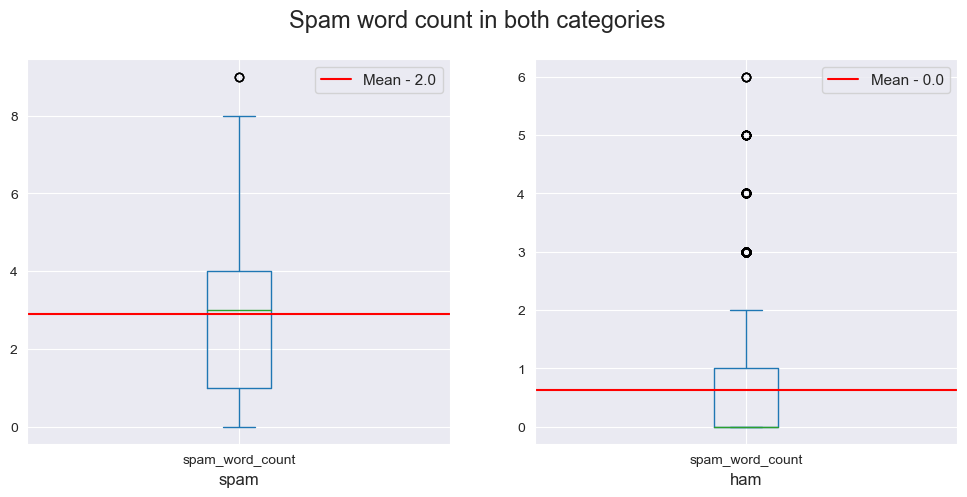

In [31]:
sns.set_style('dark')
fig,ax = plt.subplots(1,2,figsize=(12,5))
for i,category in enumerate(['spam','ham']):
    df[df.Target == category]['spam_word_count'].plot(kind='box',ax=ax[i])
    ax[i].set_xlabel(category,fontsize=12)
    Mean = df[df.Target == category]['spam_word_count'].mean()
    ax[i].axhline(Mean,label=f"Mean - {(Mean//1):}",color='red')
    ax[i].grid()
    ax[i].legend(fontsize=11)
fig.suptitle("Spam word count in both categories",fontsize=17)
plt.show()

### `4) Token count`

In [32]:
def token_count(text):
    if text == '':
        return 0
    else:
        return len(text.split())
df['token_count'] = df['messages'].apply(token_count)

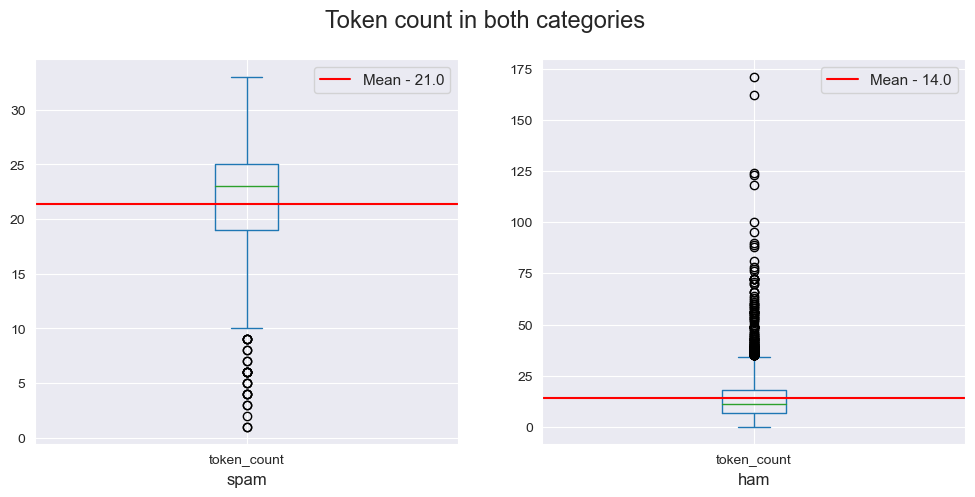

In [33]:
sns.set_style('dark')
fig,ax = plt.subplots(1,2,figsize=(12,5))
for i,category in enumerate(['spam','ham']):
    df[df.Target == category]['token_count'].plot(kind='box',ax=ax[i])
    ax[i].set_xlabel(category,fontsize=12)
    Mean = df[df.Target == category]['token_count'].mean()
    ax[i].axhline(Mean,label=f"Mean - {(Mean//1):}",color='red')
    ax[i].grid()
    ax[i].legend(fontsize=11)
fig.suptitle("Token count in both categories",fontsize=17)
plt.show()

### `5) Unique Token count`

In [34]:
def unique_token_count(text):
    if text == '':
        return 0
    else:
        return len(set(text.split()))
df['unique_token_count'] = df['messages'].apply(token_count)

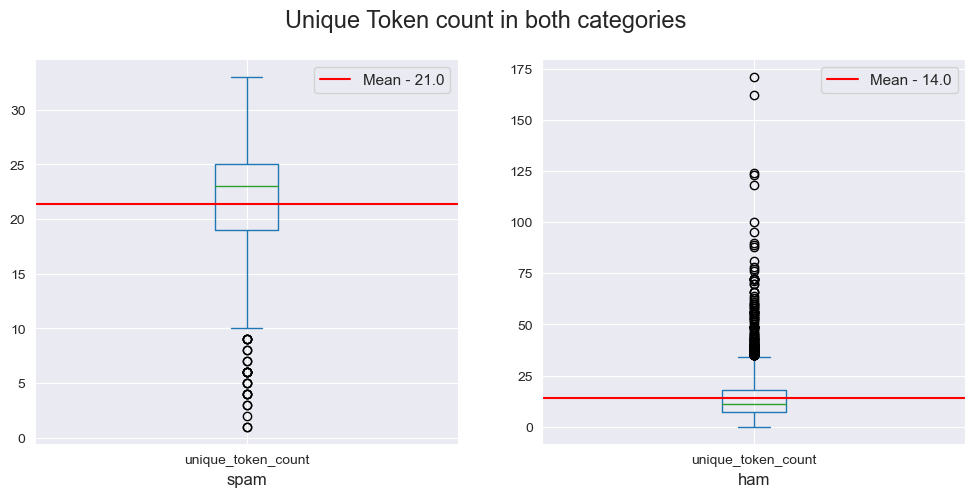

In [35]:
sns.set_style('dark')
fig,ax = plt.subplots(1,2,figsize=(12,5))
for i,category in enumerate(['spam','ham']):
    df[df.Target == category]['unique_token_count'].plot(kind='box',ax=ax[i])
    ax[i].set_xlabel(category,fontsize=12)
    Mean = df[df.Target == category]['unique_token_count'].mean()
    ax[i].axhline(Mean,label=f"Mean - {(Mean//1):}",color='red')
    ax[i].grid()
    ax[i].legend(fontsize=11)
fig.suptitle("Unique Token count in both categories",fontsize=17)
plt.show()

### `Spam & Ham word cloud before Text pre-processing`

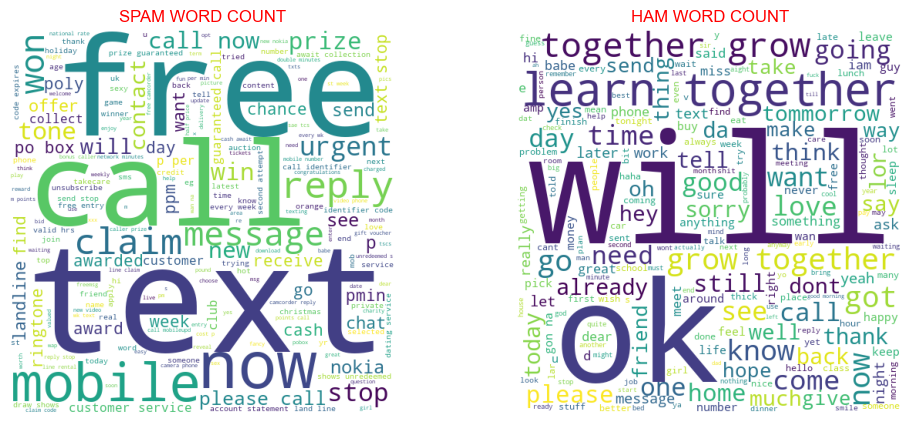

In [36]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
for i,category in enumerate(['spam','ham']):
    plt.subplot(1,2,i+1)
    text = " ".join([i for i in df[df.Target == category]['messages']])
    wordcloud = WordCloud(width=500,background_color='white',height=500).generate(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f"{category.upper()} WORD COUNT",color='red')
plt.show()

## `Text Processing`

In [37]:
trans_dict_new = {"n":'and',"fr":'for',"c":'see','b':'be','u':'you',"u\?":'you',
                  'ü':'you','wat':'what',"nah":'no',"wtf.+":'','txtú':'textyou',"rofl":'',
                  'ur':'your','muz':'must','won\'t':'will not','wkly':'tickets','lol':"",
                  'cuz':'because','yup.':'yes','r':'are','wid':'with','pls':'please','availa':'available',
                  'asap':'as soon as possible',"y\'":"why\?",'gud':'good','nyt':'night',
                  'tht':'that','frnds':'friends','timin':'timing','yup':'yes','wat':'what',
                  'wil':'will','dun':"do not","2nd":'second','2':'to','neva':'never','borin':'borin',
                  'shd':'should','nver':'never','wif':'what if','k':'ok','don‘t':"don't",'aftr':'after',
                  'you‘ll':"you'll",'frnd':'friend','iam':"i'am",'st':'something','ook':'ok',
                  'nite':'night','mrng':'morning','plz':'please','lol':'','grl':'girl','thru':'through',
                  'tmr':'tommorrow','tomo':'tommorrow','rply':'reply','wah':'wow','(ha)+':'',
                  'mins':'minutes','min':'min','urgnt':'urgent','hr':'hour','juz':'just',
                  'üll':'you will','okie':'ok','msg':'message','tonite':'to night','plm':'problem',
                  'inour':'in our','wen':'when','prob':'problem','wit':'with','txt':'text',
                  'iv':'i have','dload':'download','luv':'love','rreveal':'reveal','nxt':'next',
                  'lemme':'let me','ill':'iwill','chgs':'charges','im':'iam','nyc':'nice','yr':'year yar',
                  'txting':'texting','ufind':'you find','wks':'weeks','wana':'wantto','askd':'asked',
                  'std':'standard','wanna':'wantto','gotta':'gotto','gonna':'going to',
                  'cal':'call','xmas':'christmas','dunno':"donotknow","i 'd":'i would','imprtant':'important',
                  'msg':'message','co':"",'abt':'about','ard':'',"haven't":"have not",'imp':'imporant',
                  'ill':'i will','tc':'takecare','sd':'sweet dreams','thk':'thick','tomorw':'tommorrow',
                  'sch':'school','thanx':'thanks','pic':'picture','sm':'some','frm':'from','sat':'sat saturday',
                  'jus':'just','gal':'girl','coz':'because','nyt':'night','tomo':'tommorrow','sun':'sunday',
                  'atten':'attend','tomorrow':'tommorrow','wan2':'want to','gdeve':'good evening',
                  'tmr':'tommorrow','bcoz':'because','bday':'birthday','dontt':"do not",
                  'til':'till','urgnt':'urgent','ltgt':'learn together grow together','liao':'already',
                  'den':'then','hows':'how is','th':'','cos':'because','sec':'second',
                  'rentl':'rental','wks':'weeks','dis':'this','thuglyfe':'thug life',"‘":'','ppl':'people'}

In [38]:
def text_cleaning(text):
    # Stop words & Punctuations
    text = text.lower()
    stop_words = stopwords.words('English')
    punc = st.punctuation
    contraction_dict = {"n\'t":' not',"\'re":' are',"\'s":' is',"\'d":' would',
                   "\'ll":' will',"\'ve":' have',"\'m":' am',"won't":'will not'}
    
    # Tokenizing
    tokens = TweetTokenizer().tokenize(text)
    # tokens = regexp_tokenize(text,'\w+\'\w{0,2}|\w+\!{0,}\?{0,}')
    
    # Removing whitespaces to to have proper token
    tokens_strip = [word.strip() for word in tokens]
    
    # Mapping using lookup table
    
    lookup_process = [trans_dict_new[group] if group in trans_dict_new else group for group in tokens_strip]
    
    # contraction removal
    
    for word in lookup_process:
        if word in contraction_dict:
            index = lookup_process.index(word)
            lookup_process[index] = contraction_dict[word]
    for word in lookup_process:
        for char in contraction_dict:
            if char in word:
                char = re.sub(char,contraction_dict[char],word)
    
    # lookup_process = [word for word in lookup_process if word not in contraction]
    
    # Breaking the big tokens 'good night' ---> 'good','night'
    for new_word in lookup_process:
        if " " in new_word:
            index = lookup_process.index(new_word)
            lookup_process.pop(index)
            for position,word in enumerate(new_word.split()):
                lookup_process.insert(index+position,word)
    # Numbers Removal      
    trans_table_1 = str.maketrans("","","€£$0123456789")
    
    # Removing punctuation
    trans_table_2 = str.maketrans("","",punc)
    
    numbers_remove = [word.translate(trans_table_1) if word.isalpha() == False else word for word in lookup_process]
    punc_remove = [word.translate(trans_table_2) for word in numbers_remove]
    
    # Removing "" & word which has length more than 2 from list
    cleaning_2 = [word for word in punc_remove if word != '' if len(word) > 2]
    
    # Removing whitespaces to to have proper token
    # final_cleaning = [word.strip() for word in cleaning_2]
    
    return " ".join(cleaning_2)

- Let's take original messages and pre-process using function **'text_cleaning'**

In [39]:
df['messages'] = messages.copy()

df['messages'] = df['messages'].apply(text_cleaning)

### 4) Lemmatization

In [40]:
def lemmatization(x):
    lst = [word for word in x.split() if len(word) > 3]
    lst = [WordNetLemmatizer().lemmatize(word) for word in lst]
    return " ".join(lst)
df['messages'] = df['messages'].apply(lemmatization)

In [41]:
df['messages'] = df['messages'].str.replace(r'f{3,}|x{4,}|hm{3,}',r'')

## `Vectorization`

In [42]:
df.shape

(5169, 7)

### 2) TF-IDF (Term frequency - Inverse document frequency)

In [43]:
lg = LogisticRegression(random_state=52)

In [44]:
def TF_IDF(model,df,maximum_features=None,ngram_range=None):
    
    vector = TfidfVectorizer(max_features=maximum_features,ngram_range=ngram_range)    
    features = vector.fit_transform(df['messages'])

    Target = df['Target'].replace({'ham':0,'spam':1})
    
    new_df = pd.DataFrame(features.toarray())
    
    X_train, X_test, y_train, y_test = train_test_split(new_df, Target, test_size=0.25, random_state=42)
    
    model.fit(X_train,y_train)
    
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=52)
    
    cv_precision = cross_val_score(model,X_train,y_train,cv=cv,scoring='precision').mean()
    cv_recall = cross_val_score(model,X_train,y_train,cv=cv,scoring='recall').mean()
    cv_f1 = cross_val_score(model,X_train,y_train,cv=cv,scoring='f1').mean()
    
    return cv_precision,cv_recall,cv_f1

In [45]:
precision = []
recall = []
f1_score_ = []
for i in range(50,500,20):
    x1,x2,x3 = cv_precision,cv_recall,cv_f1 = TF_IDF(lg,df,maximum_features=i,ngram_range=(1,3))
    precision.append(x1)
    recall.append(x2)
    f1_score_.append(x3)

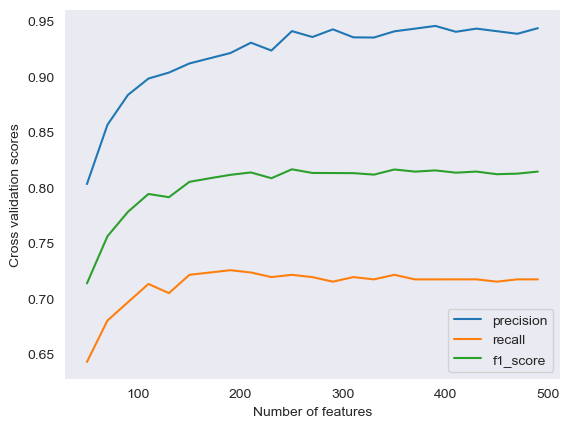

In [46]:
sns.lineplot(range(50,500,20),precision,label='precision')
sns.lineplot(range(50,500,20),recall,label='recall')
sns.lineplot(range(50,500,20),f1_score_,label='f1_score')
plt.xlabel("Number of features")
plt.ylabel("Cross validation scores")
plt.show() 

- Cross validation scores are constant over a range of 200-300
- We can select number of features in range of 200-300 as optimal features 

In [47]:
# Encoding Target column

df['Target'] = df['Target'].map({'spam':1,'ham':0})

In [48]:
# vectorizing the messages

vector = TfidfVectorizer(max_features=400,ngram_range=(1,5))    
features = vector.fit_transform(df['messages'])
features = features.toarray()
features_tfidf = pd.DataFrame(features)
other_df = df.iloc[:,2:6]

features_tfidf.index = other_df.index
X = pd.concat([features_tfidf,other_df],axis=1)
y = df['Target']

In [49]:
with open('tfidf.pickle','wb') as vec:
    pickle.dump(vector,vec)

In [50]:
X.shape

(5169, 404)

In [51]:
y.shape

(5169,)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [53]:
lg_open = LogisticRegression(random_state=54)
lg_open.fit(X_train,y_train)

LogisticRegression(random_state=54)

In [54]:
with open('logistic.pickle','wb') as log:
    pickle.dump(lg_open,log)

In [55]:
from sklearn.metrics import confusion_matrix

In [56]:
def report(fitted_model,X_train,X_test,y_train,y_test):
    
    confusion_mat = confusion_matrix(y_test,fitted_model.predict(X_test))
    
    print(confusion_mat)
    
    train_accuracy = accuracy_score(y_train,fitted_model.predict(X_train))
    test_accuracy = accuracy_score(y_test,fitted_model.predict(X_test))
    
    print(f"Training Accuracy : {train_accuracy*100:0.2f}")
    print(f"Validation Accuracy : {test_accuracy*100:0.2f}")
    print("-"*50)
    train_precision = precision_score(y_train,fitted_model.predict(X_train))
    test_precision = precision_score(y_test,fitted_model.predict(X_test))
    
    print(f"Precision (Training) : {train_precision*100:0.2f}")
    print(f"Precision (Validation) : {test_precision*100:0.2f}")
    print("-"*50)
    train_recall = recall_score(y_train,fitted_model.predict(X_train))
    test_recall = recall_score(y_test,fitted_model.predict(X_test))
    
    print(f"Recall (Training) : {train_recall*100:0.2f}")
    print(f"Recall (Validation) : {test_recall*100:0.2f}")
    print("-"*50)
    
    train_f1 = f1_score(y_train,fitted_model.predict(X_train))
    test_f1 = f1_score(y_test,fitted_model.predict(X_test))  
    
    print(f"F1 score (Training) : {train_f1*100:0.2f}")
    print(f"F1 score (validation) : {test_f1*100:0.2f}")
    print("-"*50)
    
    train_baccuracy = balanced_accuracy_score(y_train,fitted_model.predict(X_train))
    test_baccuracy = balanced_accuracy_score(y_test,fitted_model.predict(X_test))
    
    print(f"Balanced Accuracy (Training): {train_accuracy*100:0.2f}")
    print(f"Balanced Accuracy (Validation): {test_accuracy*100:0.2f}")

In [57]:
report(lg_open,X_train,X_test,y_train,y_test)

[[1476    6]
 [  27  197]]
Training Accuracy : 97.95
Validation Accuracy : 98.07
--------------------------------------------------
Precision (Training) : 95.90
Precision (Validation) : 97.04
--------------------------------------------------
Recall (Training) : 87.18
Recall (Validation) : 87.95
--------------------------------------------------
F1 score (Training) : 91.33
F1 score (validation) : 92.27
--------------------------------------------------
Balanced Accuracy (Training): 97.95
Balanced Accuracy (Validation): 98.07


In [58]:
y_test.shape

(1706,)

In [59]:
print(classification_report(y_test,lg_open.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1482
           1       0.97      0.88      0.92       224

    accuracy                           0.98      1706
   macro avg       0.98      0.94      0.96      1706
weighted avg       0.98      0.98      0.98      1706



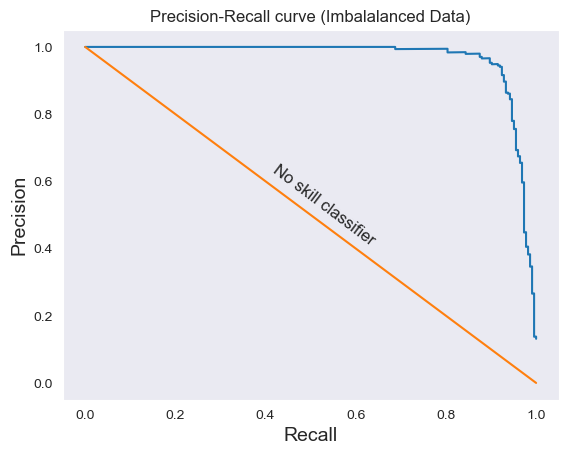

In [60]:
precision, recall, _ = precision_recall_curve(y_test,lg_open.predict_log_proba(X_test)[:,1])

plt.plot(recall,precision)
plt.plot([1,0])
plt.text(0.41,0.41,"No skill classifier",fontsize=12,rotation=-37)
plt.xlabel("Recall",fontsize=14)
plt.ylabel("Precision",fontsize=14)
plt.title("Precision-Recall curve (Imbalalanced Data)")
plt.show()

### Synthetic Minority class oversampling Technique (SMOTE)

- The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important.
--------------------------------------
- One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.
------------------------------------
- SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.
--------------------------
- Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

In [61]:
from imblearn.over_sampling import SMOTE
over_sample = SMOTE()

X_1,y_1 = over_sample.fit_resample(X,y)
print(X_1.shape)
print(y_1.shape)

Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_1, y_1, test_size=0.33, random_state=42)

(9032, 404)
(9032,)


In [62]:
lg_over = LogisticRegression(random_state=52)
lg_over.fit(Xs_train,ys_train)

LogisticRegression(random_state=52)

In [63]:
report(lg_over,Xs_train, Xs_test, ys_train, ys_test)

[[1458   49]
 [  65 1409]]
Training Accuracy : 96.93
Validation Accuracy : 96.18
--------------------------------------------------
Precision (Training) : 97.73
Precision (Validation) : 96.64
--------------------------------------------------
Recall (Training) : 96.12
Recall (Validation) : 95.59
--------------------------------------------------
F1 score (Training) : 96.92
F1 score (validation) : 96.11
--------------------------------------------------
Balanced Accuracy (Training): 96.93
Balanced Accuracy (Validation): 96.18


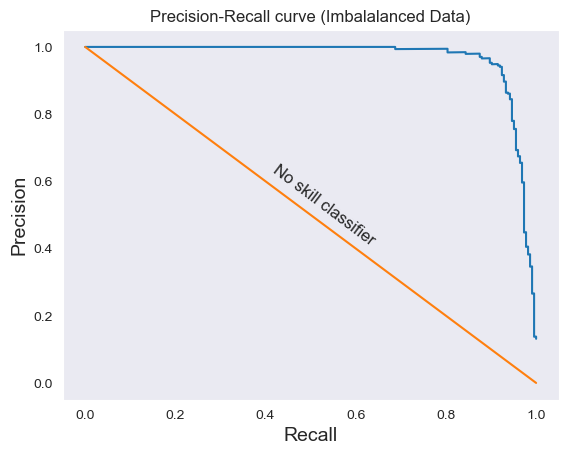

In [65]:
precision, recall, _ = precision_recall_curve(y_test,lg_open.predict_log_proba(X_test)[:,1])

plt.plot(recall,precision)
plt.plot([1,0])
plt.text(0.41,0.41,"No skill classifier",fontsize=12,rotation=-37)
plt.xlabel("Recall",fontsize=14)
plt.ylabel("Precision",fontsize=14)
plt.title("Precision-Recall curve (Imbalalanced Data)")
plt.show()

- So our classifier is efficiently classifying the mails as spam/Ham